# DL4NLP SS17 Home Exercise 02
----------------------------------
**Due until Tuesday, 02.05. at 13:00**

## Task 1 Mandatory Video (1P)
Watch [this week's mandatory video](https://www.youtube.com/watch?v=GUtlrDbHhJM&t=277s&list=PLlJy-eBtNFt6EuMxFYRiNRS07MCWN5UIA&index=5) and answer the following question: Which six activation functions are discussed during the talk?

Hint: They are shown on a summary slide among the first 30 slides.

### Solution
Slide 5-29: Sigmoid, tanh, ReLU, Leaky ReLU, Maxout, EL

## Task 2 Sentiment Polarity in Movie Reviews (9P)
The movie-review dataset (http://www.cs.cornell.edu/people/pabo/movie-review-data/) consists of movie reviews labeled with sentiment polarity (i.e. "positive review" or "negative review"). Your task is to implement a variation of the perceptron from last week which learns to identify the sentiment in a review.

#### Data
In the `hex02_data` archive, you can find a training, development and test dataset. Each line in these datasets has three entries, separated by a tab character (`\t`). The first is the movie review (available only for reference), the second is the sentiment label (`POS`itive or `NEG`ative). To facilitate the task, the third entry is a 100-dimensional vector representing the review (we'll cover in later lectures on *word embeddings* how this sentence representation has been generated).

#### Perceptron
* As the loss function, choose square-loss:
\begin{equation}
    L = \sum_{j=1}^N \ell(\mathbf{x}_j, y) = \sum_{j=1}^N (\sigma(\mathbf{x}_j \cdot \mathbf{w}) - y_j)^2
\end{equation}
* For the activation function, use the sigmoid function.

* For the weight update rule, use the following mini-batch stochastic gradient descent formula:
\begin{equation}
    w' \leftarrow w - \frac{\alpha}{|\mathcal{T}'|} \cdot \sum_{(\mathbf{x},y)\in\mathcal{T}'} \Bigl(\sigma(\mathbf{x} \cdot \mathbf{w}) - y\Bigr) \cdot \sigma'(\mathbf{x} \cdot \mathbf{w}) \cdot x^T
\end{equation}
Reminder: $\mathcal{T'}$ is a mini-batch; a random subset of the whole training data $\mathcal{T}$. A typical way of implementing random mini-batches is to randomly shuffle the whole training dataset before each epoch, then divide the training dataset into batches of size $|\mathcal{T'}|$. Consider setting the numpy random seed for reproducible results.

* Use the 100-dimensional vectors from the datasets for the input vectors $\mathbf{x}$. Encode the corresponding label as $y=1$ for `POS` and $y=0$ for `NEG` (i.e. according to the co-domain of the sigmoid activation function). **Append a trailing 1 to each input vector $\mathbf{x}$ for the bias (cf. lecture 01, slide 92).**

* Initialize the weight vector via `w=np.random.normal(0,1,(N,1))`, where $N$ is the dimensionality of your input data.

#### Hints on the Submission Format
* Please submit your python code for all the tasks where it is applicable. Make sure to include comments explaining complicated/non-obvious sections of your code.
* Please also submit a copy of the console output of your code execution. Your code might run in 10 minutes on your watercooled battlestation, but it might not run in 10 minutes for the person who corrects your home exercises. Thank you!


### Task 2.1 Dataset reader (1P)
Implement a reader for the dataset files which returns the input vectors $\mathbf{x}$ and labels $y$ as numpy arrays. The shape and number of returned arrays is up to you.

In [1]:
import numpy as np
import os

label_pos = 1
label_neg = 0

data_dim = 100
data_dim_with_bias = data_dim + 1

def read_dataset(src):
    """Reads a dataset from the specified path and returns input vectors and labels in an array of shape (n, 101)."""
    with open(src, 'r') as src_file:
        # preallocate memory for the data
        num_lines = sum(1 for line in src_file)
        data = np.empty((num_lines, data_dim_with_bias), dtype=np.float16)
        labels = np.empty((num_lines, 1), dtype=np.float16)

        # reset the file pointer to the beginning of the file
        src_file.seek(0)
        for i, line in enumerate(src_file):
            _, str_label, str_vec = line.split('\t')
            labels[i] = label_pos if str_label.split('=')[1] == "POS" else label_neg
            data[i,:data_dim] = [float(f) for f in str_vec.split()]
            data[i,data_dim] = 1
    return data, labels

def get_dataset(src_folder, name="train"):
    path = os.path.join(src_folder, "rt-polarity.{}.vecs".format(name))
    return read_dataset(path)

def get_random_batches(X, y, batch_size):
    perm = np.random.permutation(len(y))
    X = X[perm]
    y = y[perm]
    # when using array_split for 100 datapoints and batch size 33 one would get batches [33, 33, 33, 1]
    X_batches = np.array_split(X, len(y)//batch_size)
    y_batches = np.array_split(y, len(y)//batch_size)
    return X_batches, y_batches

# load the data
train_x, train_y, = get_dataset("DATA", "train")
dev_x, dev_y = get_dataset("DATA", "dev")
test_x, test_y = get_dataset("DATA", "test")

### Task 2.2 Numpy implementation (5P)

a) Implement the perceptron stated above only using numpy. Include a method which computes the square loss and the accuracy of the model, given a dataset and a weight vector `w`. (3P)

Hint: In order to compute the accuracy, you need to find a meaningful way to interpret your perceptron's prediction $\sigma(\mathbf{x} \cdot \mathbf{w})$ for a given test input $\mathbf{x}$ and trained weights $\mathbf{w}$.

In [2]:
import progressbar as pb

test_every_ith_epoch = 20

def sigmoid(v):
      return 1.0 / (1+np.exp(-v))

def train_np(train_x, train_y, w, epochs, batch_size, learning_rate):

    def epoch(train_x, train_y, w_init, batch_size, learning_rate):
        w = w_init
        train_x_batches, train_y_batches = get_random_batches(train_x, train_y, batch_size)
        for X_batch, y_batch in zip(train_x_batches, train_y_batches):
            grad = 0
            for x, y in zip(X_batch, y_batch):
                sigxw = sigmoid(np.dot(x, w))
                grad += (sigxw-y) * sigxw * (1 - sigxw) * x
            # average the gradient
            grad /= len(y_batch)
            w -= learning_rate * grad
        return w
  
    # keep track of losses on the train and dev sets for the plot in Task 2.2 b)
    losses_train = []
    losses_dev = []
    bar = pb.ProgressBar(max_value=epochs)
    for i in bar(range(epochs)):
        w = epoch(train_x, train_y, w, batch_size, learning_rate)
    
        # compute the loss every i epochs
        if not i%test_every_ith_epoch:
            loss, _ = test_np(dev_x, dev_y, w)
            losses_dev.append(loss)      
            loss, _ = test_np(train_x, train_y, w)
            losses_train.append(loss)
    return w, losses_train, losses_dev


def test_np(test_x, test_y, w):
    predictions = [sigmoid(np.dot(x, w)) for x in test_x]
    predictions_discrete = [np.rint(pred) for pred in predictions]
    
    n = len(test_y)    
    mean_square_loss = sum([(pred - y)**2 for pred, y in zip(predictions, test_y)])/n
    accuracy = sum([pred == y for pred, y in zip(predictions_discrete, test_y)])/n

    return mean_square_loss, accuracy

def run_numpy(epochs=100, batch_size=10, learning_rate=0.01):
    np.random.seed(seed=42)
    np.seterr(all='ignore')

    w_init = np.random.normal(0, 1, (data_dim_with_bias))
    w,losses_train,losses_dev = train_np(train_x, train_y, w_init, epochs, batch_size, learning_rate)

    #print results on dev and test
    loss, accuracy = test_np(dev_x, dev_y, w)
    print("Loss on dev after {} epochs: {}, accuracy: {}".format(epochs, loss, accuracy))
    loss, accuracy = test_np(test_x, test_y, w)
    print("Loss on test after {} epochs: {}, accuracy: {}".format(epochs, loss, accuracy))

    # return values for the plot
    return losses_train, losses_dev

b) Train your perceptron on the training data and observe its accuracy on the **development** set. Start with batch size $|\mathcal{T}'| = 10$, learning rate $\alpha = 0.01$ and 100 epochs. Experiment with different values for these three hyperparameters. Can you find a configuration which beats 70% accuracy on the development set? Report your best configuration and both the loss and accuracy it reaches on the **development and test** sets. (1P)

In [3]:
# initial parameters
_,_ = run_numpy()
# console output:
# Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
# Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]

# better parameters
_,_ = run_numpy(epochs=500, batch_size=25, learning_rate=0.05)
# console output:
# Loss on dev after 500 epochs: [ 0.27939337], accuracy: [ 0.71732333]
# Loss on test after 500 epochs: [ 0.29846779], accuracy: [ 0.69981238]

100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:16
  0% (1 of 500) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:01:05

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (500 of 500) |######################################################################| Elapsed Time: 0:00:40 Time: 0:00:40  0% (4 of 500) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:49


Loss on dev after 500 epochs: [ 0.27939337], accuracy: [ 0.71732333]
Loss on test after 500 epochs: [ 0.29846779], accuracy: [ 0.69981238]


c) Create a plot similar to the one from lecture 02, slide 18, i.e. plot the loss on the training set and the development set vs. the number of training epochs. For this purpose, run your perceptron with batch size $|\mathcal{T}'| = 1$ and learning rate $\alpha = 0.001$ for a large number of epochs (>2500). Which number of epochs is reasonable? Why does the loss on the development set **not** increase over time, contrary to the figure from the lecture? (1P)

Hint: For comparable results in the plot, normalize the loss by the number of instances in the training/test dataset.

100% (2500 of 2500) |####################################################################| Elapsed Time: 0:06:43 Time: 0:06:43  0% (1 of 2500) |                                                                        | Elapsed Time: 0:00:00 ETA: 0:10:14


Loss on dev after 2500 epochs: [ 0.27392119], accuracy: [ 0.72357724]
Loss on test after 2500 epochs: [ 0.3056598], accuracy: [ 0.6916823]


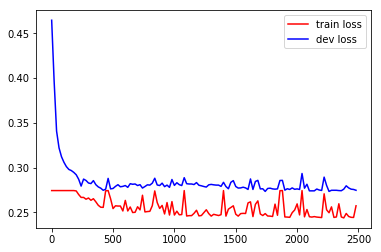

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

losses_train, losses_dev = run_numpy(epochs=2500, batch_size=1, learning_rate=0.001)

x_vals = [test_every_ith_epoch*i for i in range(len(losses_train))]	
plt.plot(x_vals, losses_train, '-r', label='train loss')
plt.plot(x_vals, losses_dev, '-b', label='dev loss')
_ = plt.legend()

### Solution
Improvement in terms of loss on the development set stagnates after roughly 800 epochs. A good early stopping point could therefore be 800 epochs. The loss on the development set does not start to increase for late epochs because, roughly speaking, the data is more complex than the model. The linear decision boundary of our perceptron is not expressive enough to overfit noise in the training data.

### Task 2.3 TensorFlow (3P)
[Install TensorFlow](https://www.tensorflow.org/install/) on your machine and reimplement the perceptron with TensorFlow. Using the initial hyperparameter configuration mentioned in Task 2.2 b), [compare the runtime](http://stackoverflow.com/a/7370824) for training your TensorFlow and your numpy perceptrons for an average of 10 executions. Which one runs faster on your machine?

In [5]:
import tensorflow as tf
import progressbar as pb
import time

class Model:
    def __init__(self, learning_rate):
        # set up the model
        self.X = tf.placeholder(tf.float16, shape=(None, data_dim_with_bias))
        self.y = tf.placeholder(tf.float16, shape=(None, 1))
        self.w = tf.get_variable("weights",
                            shape=(data_dim_with_bias, 1),
                            dtype=tf.float16,
                            initializer=tf.random_normal_initializer())
        self.perceptron = tf.sigmoid(tf.matmul(self.X, self.w))
        self.loss = tf.losses.mean_squared_error(self.y, self.perceptron)
        self.sgd = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)

def train_tf(sess, model, train_x, train_y, epochs, batch_size):    
    bar = pb.ProgressBar(max_value=epochs)
    for i in bar(range(epochs)):
        train_x_batches, train_y_batches = get_random_batches(train_x, train_y, batch_size)
        for X_batch, y_batch in zip(train_x_batches, train_y_batches):
            _, w_val = sess.run([model.sgd, model.w], feed_dict={model.X:X_batch, model.y:y_batch})
    
def test_tf(sess, model, test_x, test_y):
    loss, predictions = sess.run([model.loss, model.perceptron], feed_dict={model.X:test_x, model.y:test_y})
    accuracy = np.sum(np.equal(test_y, np.rint(predictions))) / len(test_y)
    return loss, accuracy
                  
def run_tensorflow(epochs=100, batch_size=10, learning_rate=0.01):
    tf.set_random_seed(42)
    
    # set up the model
    model = Model(learning_rate)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_tf(sess, model, train_x, train_y, epochs, batch_size)
        
        #print results on dev and test
        loss, accuracy = test_tf(sess, model, dev_x, dev_y)
        print("Loss on dev after {} epochs: {}, accuracy: {}".format(epochs, loss, accuracy))
        loss, accuracy = test_tf(sess, model, test_x, test_y)
        print("Loss on test after {} epochs: {}, accuracy: {}".format(epochs, loss, accuracy))
    
    tf.reset_default_graph()

In [6]:
def speed_comparison(runs=10):
    timings_by_system = {}
    for train_system in [run_numpy, run_tensorflow]:
        timings = np.empty((runs))
        for r in range(runs):
            t0 = time.time()
            train_system(epochs=100, batch_size=10, learning_rate=0.01)
            t1 = time.time()
            timings[r] = t1 - t0
        timings_by_system[train_system.__name__] = np.mean(timings)
    print("Average training time (seconds): " + str(timings_by_system))
    
speed_comparison()
# console output:
# Average training time (seconds): {'run_numpy': 8.8820782661437985, 'run_tensorflow': 22.123092341423035}

100% (100 of 100) |######################################################################| Elapsed Time: 0:00:08 Time: 0:00:08  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:13

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:14

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:15

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:10
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:15

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:11
  1% (1 of 100) |                                                                         | Elapsed Time: 0:00:00 ETA: 0:00:17

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:09 Time: 0:00:09  3% (3 of 100) |##                                                                       | Elapsed Time: 0:00:00 ETA: 0:00:13
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: [ 0.3056598], accuracy: [ 0.69043152]
Loss on test after 100 epochs: [ 0.32520324], accuracy: [ 0.66979362]


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:27 Time: 0:00:27  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:27
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.29010888934135437, accuracy: 0.7066916823014384
Loss on test after 100 epochs: 0.30032747983932495, accuracy: 0.6954346466541589


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:28 Time: 0:00:28  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:25
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.30025187134742737, accuracy: 0.6985616010006254
Loss on test after 100 epochs: 0.30845949053764343, accuracy: 0.6885553470919324


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:27 Time: 0:00:27  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:28
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.5084272623062134, accuracy: 0.4915572232645403
Loss on test after 100 epochs: 0.49211055040359497, accuracy: 0.5078173858661663


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:27 Time: 0:00:27  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:30
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.29484695196151733, accuracy: 0.7035647279549718
Loss on test after 100 epochs: 0.30881547927856445, accuracy: 0.6904315196998124


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:25 Time: 0:00:25  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:22
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.31006625294685364, accuracy: 0.6866791744840526
Loss on test after 100 epochs: 0.31565889716148376, accuracy: 0.6804252657911195


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:24 Time: 0:00:24  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:23
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.5059831738471985, accuracy: 0.49405878674171355
Loss on test after 100 epochs: 0.49456387758255005, accuracy: 0.5053158223889931


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:28 Time: 0:00:28  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:23
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.2914016842842102, accuracy: 0.7048155096935584
Loss on test after 100 epochs: 0.3072618544101715, accuracy: 0.6898061288305191


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:28 Time: 0:00:28  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:27
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.3085114657878876, accuracy: 0.6904315196998124
Loss on test after 100 epochs: 0.3167217969894409, accuracy: 0.6804252657911195


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:25 Time: 0:00:25  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:25
N/A% (0 of 100) |                                                                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Loss on dev after 100 epochs: 0.2966122031211853, accuracy: 0.7023139462163852
Loss on test after 100 epochs: 0.2940548360347748, accuracy: 0.7035647279549718


100% (100 of 100) |######################################################################| Elapsed Time: 0:00:27 Time: 0:00:27  2% (2 of 100) |#                                                                        | Elapsed Time: 0:00:00 ETA: 0:00:23


Loss on dev after 100 epochs: 0.28633901476860046, accuracy: 0.7098186366479049
Loss on test after 100 epochs: 0.2988188564777374, accuracy: 0.6979362101313321
Average training time (seconds): {'run_tensorflow': 27.315894603729248, 'run_numpy': 9.2817548751831058}
